In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
import math

In [2]:
#Seleccionar todos los datos de 'train'
array_df = [pd.read_csv('Data/train/data_0'+ str(csvnum) +'.csv') for csvnum in np.arange(1,15+1)]

In [3]:
for df in array_df:
    #Se cambia el nombre de las columnas para que tengan un formato acorde al de Python
    df.columns = ["date" , "ambient_temperature" , "ambient_pressure" , "compressor_speed" , "compressor_discharge_pressure" , "gas_generator_discharge_pressure" , "high _pressure_turbine_inlet_temperature" , "compressor_discharge_temperature" , "low_pressure_turbine_inlet_temperature" , "exhaust_temperature" , "ambient_relative_humidity" , "water_to_dry_air_ratio" , "power"]

In [4]:
# longitud de cada dataframe
array_len_df = [len(df) for df in array_df]

In [5]:
#nuevo index en el dataframe de los datos 
for csvnum in np.arange(1,15+1):
    array_df[csvnum-1].set_axis(np.arange(sum(array_len_df[:csvnum-1]), sum(array_len_df[:csvnum])), axis='index', inplace=True)

In [6]:
#unir todos los datos
df_conc = pd.concat(array_df) 

In [7]:
#separar datos de entrenamiento y validacion
df_train = df_conc.iloc[np.arange(366*12)]
df_val = df_conc.iloc[np.arange(366*12, 366*15)]

In [8]:
#quitar valores vacios en entrenamiento
df_train = df_train.dropna()

In [9]:
#poner en 0 los valores vacios en validacion
df_val = df_val.fillna(0)

In [10]:
len_train = len(df_train)
len_val = len(df_val)

# Creamos un metodo basado en el analisis exploratorio, usara dos regresiones lineales, dependiendo en si los datos son tipo 'azul' o 'naranja'. Para determinar el tipo, usamos k-Vecinos más cercanos

In [11]:
#Clase para mi modelo, con un metodo para entrenamiento y otro de prediccion
#los hyperparametros son la línea de separación para los datos de entrenamiento
# (linear_cut_slope, linear_cut_intercept) y la k del k-Means (knum)

class MyModel():
    # default constructor
    def __init__(self, linear_cut_slope = 1640, linear_cut_intercept = 0, knum = 3):
        self.linear_cut_slope = linear_cut_slope
        self.linear_cut_intercept = linear_cut_intercept
        self.knum = knum
        
    # a method for printing data members
    def train(self, df_tr):
        self.df_tr = df_tr #dataframe for training
        
        # Linear Regression EXH_T vs POWER 
        #(orange data)
        X_tr = np.array(df_tr['exhaust_temperature']).reshape(-1,1)
        Y_tr = np.array(df_tr['power']).reshape(-1,1)

        self.orange_model = LinearRegression().fit(X_tr, Y_tr)

        # KNeighbors data election with CDP and CMP_SPEED
        self.bluemask = df_tr['power'] < (self.linear_cut_slope)*df_tr['compressor_discharge_pressure'] + (self.linear_cut_intercept)
        df_X_kmeans = df_tr[['compressor_discharge_pressure', 'compressor_speed']].to_numpy()
        df_Y_kmeans = self.bluemask #np.array([0 for i in df_X_kmeans])
        
        self.chooseblue = KNeighborsClassifier(self.knum)
        self.chooseblue.fit(df_X_kmeans, df_Y_kmeans)
        
        # Linear Regression CDP vs POWER 
        #(blue data)
        X_tr = np.array(df_tr['compressor_discharge_pressure']).reshape(-1,1)
        Y_tr = np.array(df_tr['power']).reshape(-1,1)
        
        self.blue_model = LinearRegression().fit(X_tr[self.bluemask], Y_tr[self.bluemask])
                
    def predict(self, df_pr): #dataframe for predicting
        
        # Predict with Linear Regression EXH_T vs POWER
        X_prt = np.array(df_pr['exhaust_temperature']).reshape(-1,1)
        Y_prt = self.orange_model.predict(X_prt)

        # Predict with Linear Regression CDP vs POWER ()
        X_prt1 = np.array(df_pr['compressor_discharge_pressure']).reshape(-1,1)
        Y_prt1 = self.blue_model.predict(X_prt1) 
        
        # Blue or orange prediction with KNeighbors data
        self.bluelabel = self.chooseblue.predict(df_pr[['compressor_discharge_pressure', 'compressor_speed']].to_numpy())

        #change prediction if data is blue type with bluelabel
        for i in np.arange(len(Y_prt)):
            if (self.bluelabel[i] == True):
                Y_prt[i] = Y_prt1[i]

        return Y_prt

# Aplicación a los datos de validación

In [12]:
#Llamando la clase
Modelo1 = MyModel()

In [13]:
#Entrenamiento
Modelo1.train(df_train)

In [14]:
#Prediccion en validacion
y_val_pred = Modelo1.predict(df_val)

In [15]:
#Calcular como funcionó en la métrica
MSE = mean_squared_error(df_val['power'], y_val_pred)
RMSE = math.sqrt(MSE)

In [16]:
RMSE

12031.61570726934

# Aqui podemos ver la aplicacion de los k nearest para el anterior modelo

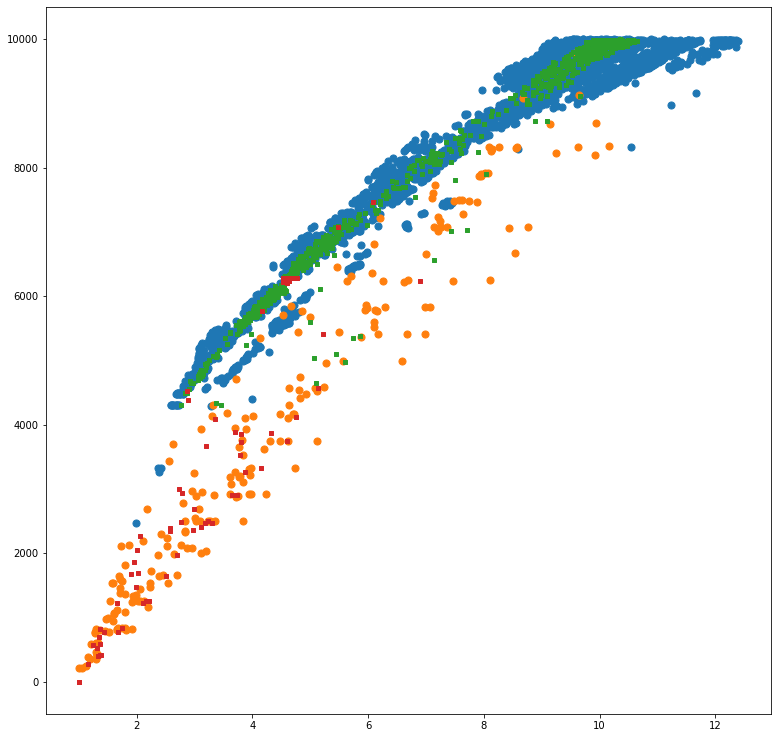

In [17]:
f, ax = plt.subplots(figsize=(13, 13))
plt.scatter(df_train['compressor_discharge_pressure'][Modelo1.bluemask], df_train['compressor_speed'][Modelo1.bluemask], s = 50)
plt.scatter(df_train['compressor_discharge_pressure'][Modelo1.bluemask==False], df_train['compressor_speed'][Modelo1.bluemask==False], s = 50)
plt.scatter(df_val['compressor_discharge_pressure'][Modelo1.bluelabel], df_val['compressor_speed'][Modelo1.bluelabel], marker = "s", s = 15)
plt.scatter(df_val['compressor_discharge_pressure'][Modelo1.bluelabel==False], df_val['compressor_speed'][Modelo1.bluelabel==False], marker = "s", s = 15)

# Validación del método y fijación de los hiperparametros

In [18]:
num_folds = 4
k_choices = [1, 2, 3, 5, 8, 10]
intercept_choices = [-250, -125, 0, 125, 250, 375]


df_train_folds = np.array_split(df_train, 4)
accuracies = {}

In [19]:
for intercept_par in intercept_choices:
    for k in k_choices:
        accuracies[(k,intercept_par)] = [] 

        for i_folds in np.arange(num_folds):

            classifier = MyModel(linear_cut_intercept = intercept_par, knum = k)

            df_train_foldset = pd.concat(df_train_folds[:i_folds] + df_train_folds[i_folds+1:])
            df_test_foldset = df_train_folds[i_folds]

            classifier.train(df_train_foldset)

            y_val_pred = classifier.predict(df_test_foldset)

            MSE = mean_squared_error(df_test_foldset['power'], y_val_pred)
            RMSE = math.sqrt(MSE)

            #print(RMSE)
            accuracies[(k,intercept_par)].append(RMSE)

In [20]:
accuracies

{(1, -250): [1099.1346176699706,
  1186.1864374990985,
  458.33667232959084,
  801.0373755391048],
 (2, -250): [1176.1748988136167,
  1213.7415163514963,
  506.85154457416917,
  753.791525556725],
 (3, -250): [1104.2329908659556,
  1180.9054821146892,
  560.7621590359508,
  792.3219989650157],
 (5, -250): [1114.9724318738902,
  1093.1364212209833,
  633.0782248148932,
  853.0426108837495],
 (8, -250): [1100.1131734566654,
  1101.7766370853446,
  621.17422362265,
  852.2516153111765],
 (10, -250): [1092.2061351219018,
  1119.9829962622762,
  616.6459600142534,
  849.1563659031169],
 (1, -125): [1081.6759188698131,
  1185.5624089401147,
  438.5999500526191,
  800.0040307516825],
 (2, -125): [1154.3469506957956,
  1199.4709511826977,
  464.32929221348894,
  750.1794890841571],
 (3, -125): [1104.5145435753025,
  1180.84677577633,
  559.3149696514487,
  790.6950726109642],
 (5, -125): [1115.1828735946954,
  1196.1396277874614,
  631.5002747963688,
  851.2217841515505],
 (8, -125): [1100.338

In [21]:
for intercept_par in intercept_choices:
    for k in k_choices:
        print(accuracies[(k,intercept_par)], k,intercept_par)

[1099.1346176699706, 1186.1864374990985, 458.33667232959084, 801.0373755391048] 1 -250
[1176.1748988136167, 1213.7415163514963, 506.85154457416917, 753.791525556725] 2 -250
[1104.2329908659556, 1180.9054821146892, 560.7621590359508, 792.3219989650157] 3 -250
[1114.9724318738902, 1093.1364212209833, 633.0782248148932, 853.0426108837495] 5 -250
[1100.1131734566654, 1101.7766370853446, 621.17422362265, 852.2516153111765] 8 -250
[1092.2061351219018, 1119.9829962622762, 616.6459600142534, 849.1563659031169] 10 -250
[1081.6759188698131, 1185.5624089401147, 438.5999500526191, 800.0040307516825] 1 -125
[1154.3469506957956, 1199.4709511826977, 464.32929221348894, 750.1794890841571] 2 -125
[1104.5145435753025, 1180.84677577633, 559.3149696514487, 790.6950726109642] 3 -125
[1115.1828735946954, 1196.1396277874614, 631.5002747963688, 851.2217841515505] 5 -125
[1100.338258440857, 1101.7585067040288, 619.7109162712446, 850.4487903815495] 8 -125
[1092.2644702488415, 1119.8259609198958, 615.18743230537

# Haciendo una revision de los valores, vemos que la validación toma buenos valores para k =2 y b = 125 